In [1]:
import numpy as np
import math

# SGT_REWARDS = np.array([-50,-5,20,-70])
# SGT_THREATS = np.array([-2,-3,-10,-8])
SGT_REWARDS = np.array([-50,-5,20,10])
SGT_THREATS = np.array([-20,-30,-100,-40])
# SGT_REWARDS = np.array([-25,-25,25,25])
# SGT_THREATS = np.array([25,25,-25,-25])
refpoint = np.array([0,0])
max_reward = np.max(SGT_REWARDS)
max_threat = np.max(SGT_THREATS)

p = 0.04
W = int(1/p)+1
tau = np.array([0.1,0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256])
N_tau = np.size(tau)
epsilon = np.arange(11)*0.1
epsilon = np.around(epsilon, decimals = 2)
N_eps = np.size(epsilon)

def softmax(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        for w in range(W):
            weight = [w*p, 1.0-w*p]
            temp = (weight[0]*R + weight[1]*T)/tau[n]
            P[w,n,:] = np.exp(temp)/np.sum(np.exp(temp))
    learner = "Softmax One"
    return np.round(P,3), learner

def selective_attention(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        ex_R = np.exp((R - np.max(R))/tau[n])
        ex_T = np.exp((T - np.max(T))/tau[n])
        weight_R = ex_R/np.sum(ex_R)
        weight_T = ex_T/np.sum(ex_T)
        for w in range(W):
            weight = [w*p,1.0-w*p]
            P[w,n,:] = weight[0]*weight_R + weight[1]*weight_T
    learner = "Softmax Two"
    return np.round(P,3), learner



def hypervolume(R,T, refpoint):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        for w in range(W):
            temp = np.zeros(4)
            for i in range(4):
                temp[i] = pow(abs(R[i] - np.min(R) +refpoint[0]), w*p/tau[n])*pow(abs(T[i] - np.min(T)+refpoint[1]), (1-w*p)/tau[n])
            #print(temp)
            P[w,n,:] = temp/np.sum(temp)
    learner = "Hypervolume"
    return P, learner

def eps_greedy(R,T,eps):
    P = np.zeros((W,N_eps,4))
    temp = np.zeros(4)
    for n in range(N_eps):
        for w in range(W):
            weight = [w*p, 1-w*p]
            for i in range(4):
                temp[i] = weight[0]*R[i] + weight[1]*T[i]
            k = np.argmax(temp)
            for i in range(4):
                if i == k:
                    P[w,n,i] = 1-0.75*eps[n]
                else:
                    P[w,n,i] = 0.25*eps[n]
    
    learner = "Epsilon-Greedy"
    return P, learner
        


In [2]:
#---- this only runs the selected decision_maker-------------
def run(decision_maker):
    reward_regret = np.zeros((W,N_tau))
    threat_regret = np.zeros((W,N_tau))
    prob, learner_type = decision_maker(SGT_REWARDS,SGT_THREATS)
    for w in range(W):
        for n in range(N_tau):
            reward_regret[w,n] = max_reward - np.dot(prob[w,n], SGT_REWARDS)
            threat_regret[w,n] = max_threat - np.dot(prob[w,n], SGT_THREATS)

    return reward_regret, threat_regret
regret = max_reward - SGT_REWARDS
thr_regret = max_threat -SGT_THREATS


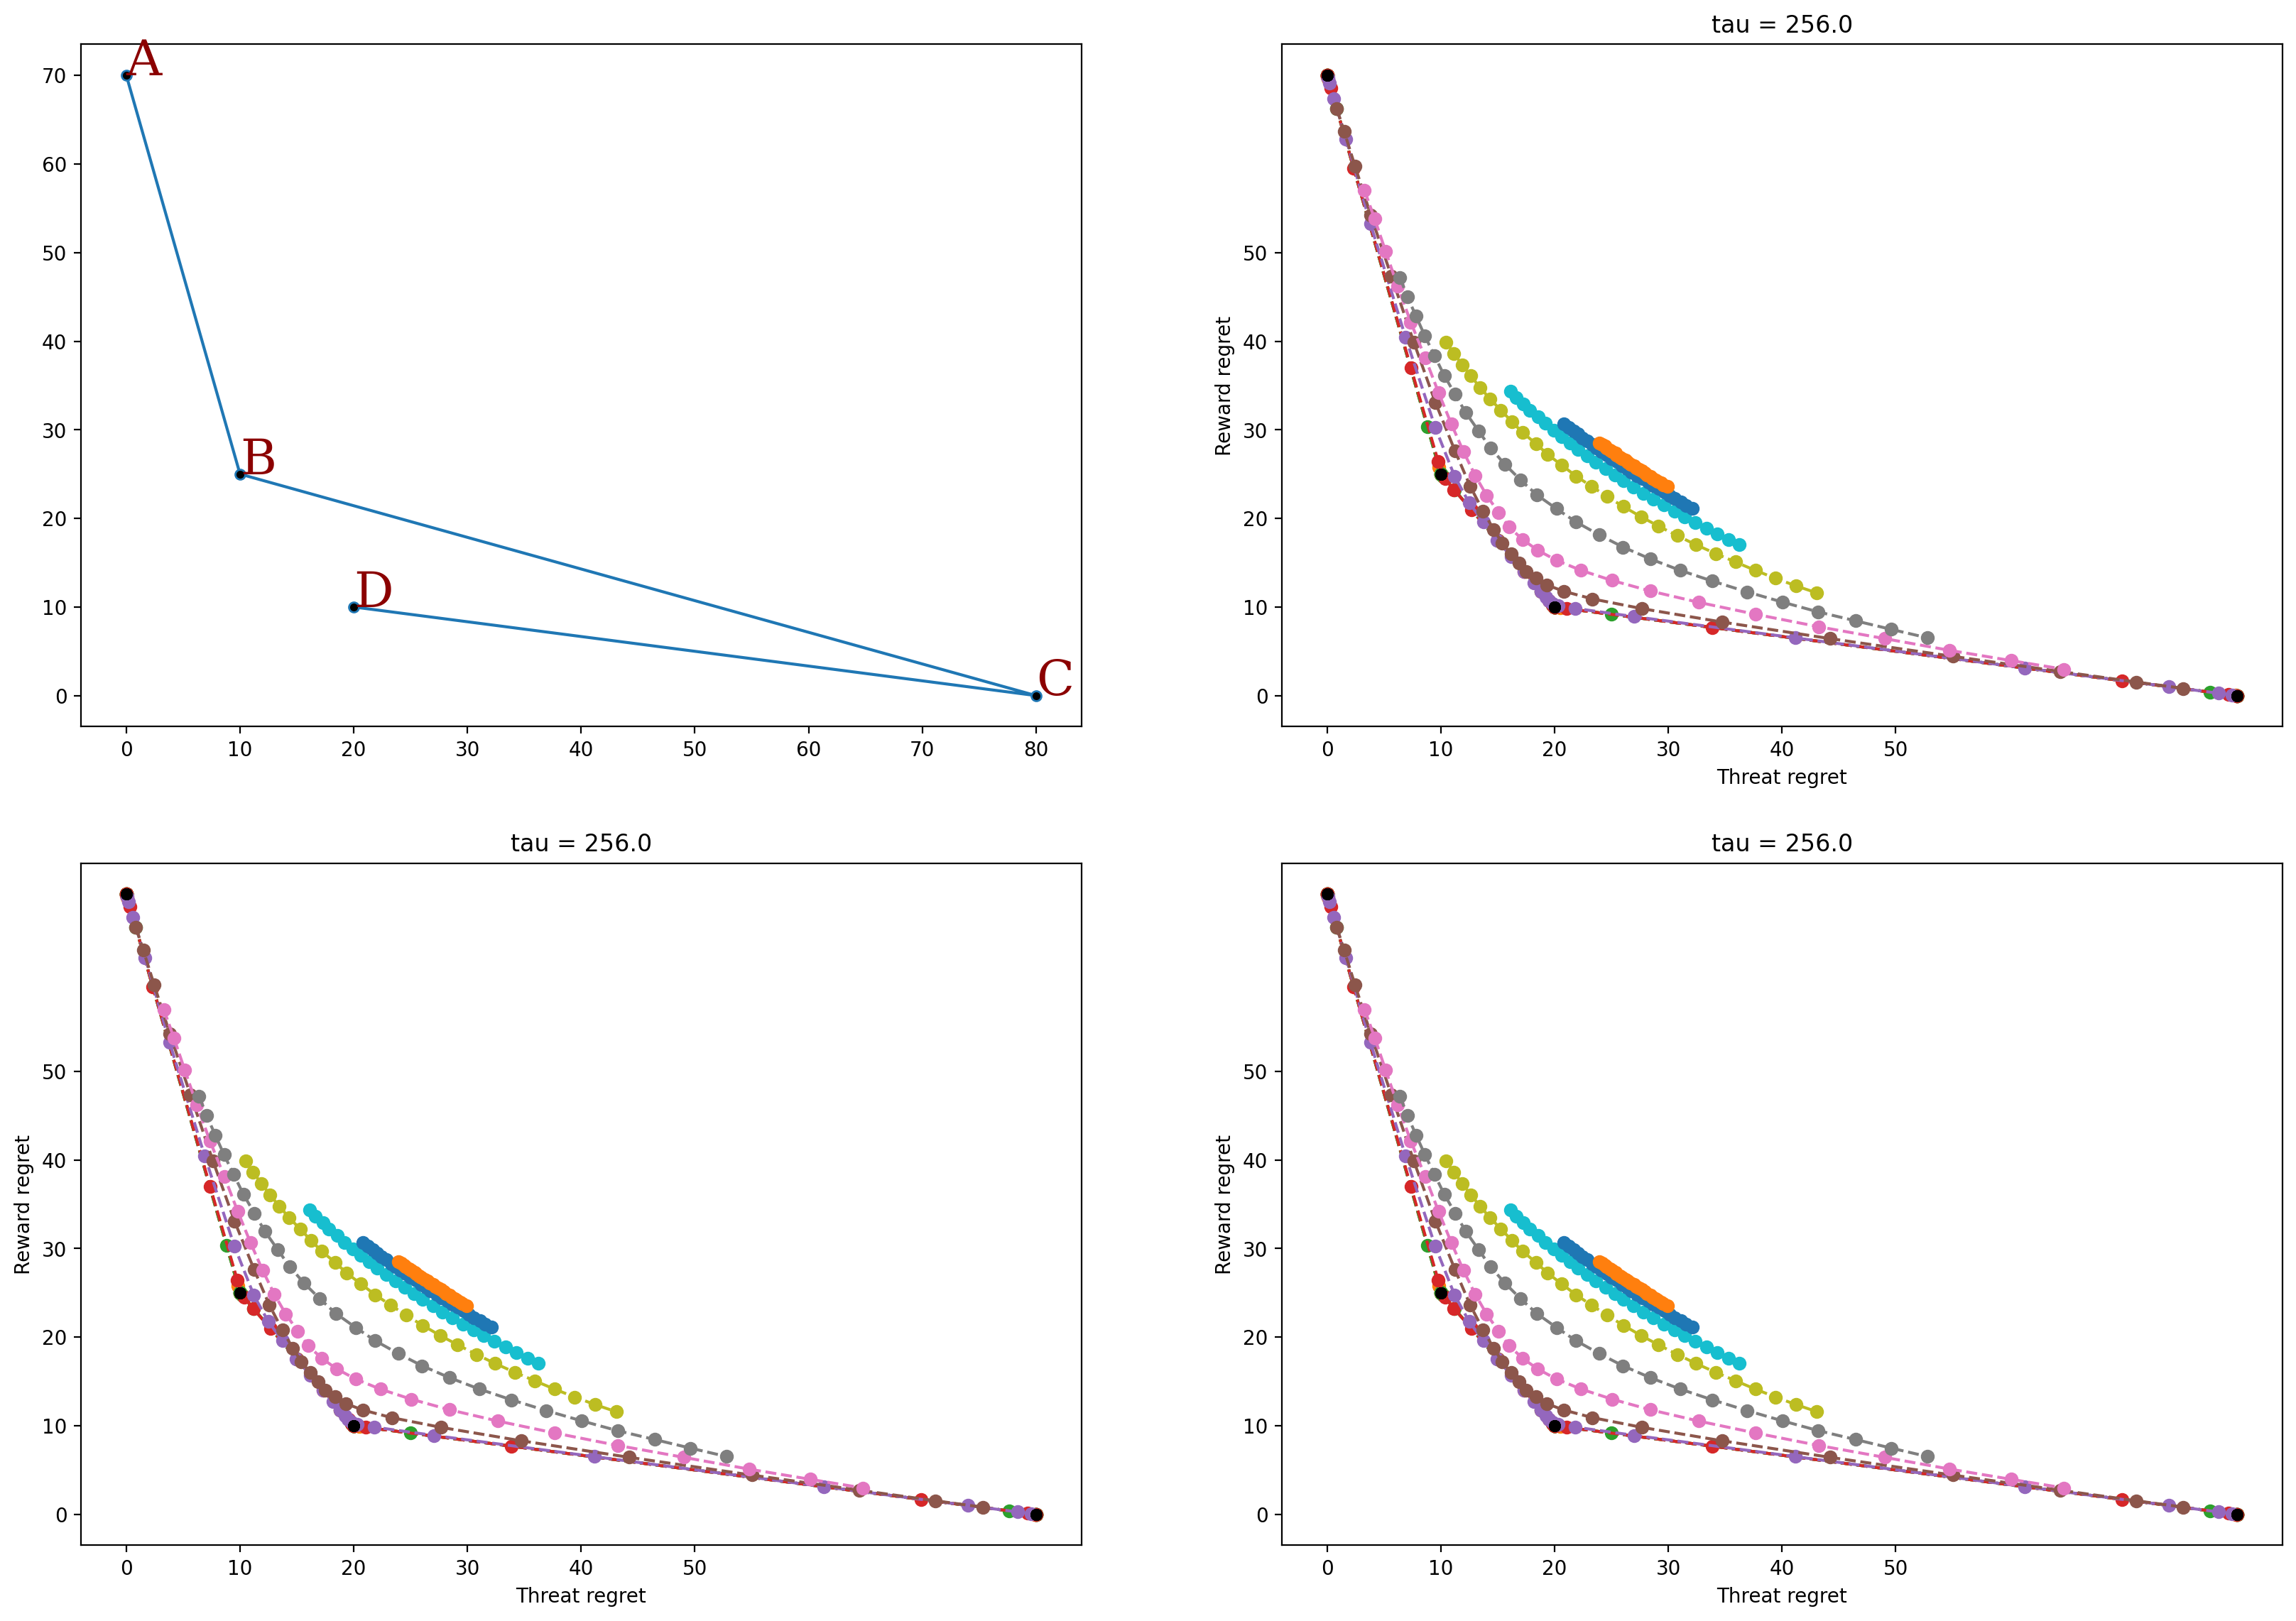

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from shapely.geometry import Polygon
figure(figsize=(20, 14), dpi=200)


#----------------------plotting the individual policies by w and tau-------------------------------
plt.figure(1)
plt.subplot(2,2,1)
plt.plot(thr_regret,regret, "-", marker = "o", markersize = 5, markerfacecolor = "black")
thr_regret = np.round(thr_regret, 2)
regret = np.round(regret, 2)
lbls = ['A ', 'B', 'C', 'D']
font = {'family': 'serif',
    'color':  'darkred',
    'weight': 'normal',
    'size': 25,
    }
for i in range(4):
    plt.text(thr_regret[i], regret[i], lbls[i], fontdict = font )

for k in range(1,4):
    plt.subplot(2,2,k+1)
    
    for n in range(N_tau):
        plt.plot(thr_regret,regret, "kx", marker = "o", markersize = 5, markerfacecolor = "black")
        thr_regret = np.round(thr_regret, 2)
        regret = np.round(regret, 2)
        lbls = ['A ', 'B', 'C', 'D']
        font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 25,
            }
#         for i in range(4):
#             plt.text(thr_regret[i], regret[i], lbls[i], fontdict = font )
        y = reward_regret[:,n]
        x = threat_regret[:,n]
        #plt.subplot(3,4,n+1)
        plt.plot(x, y, '--o')
        plt.xlabel("Threat regret")
        plt.ylabel("Reward regret")
        plt.xticks(np.arange(6)*10)
        plt.yticks(np.arange(6)*10)
        plt.title("tau = "+str(tau[n]))
    # plt.suptitle("Pareto front of Threat-Reward Regret Pairs by Explicitly Solving for the Q-values for "+learner_type , fontsize=15) 
    # plt.scatter(refpoint[0], refpoint[1], marker = "o", s = 200)
    # plt.text(refpoint[0], refpoint[1],s = "Reference Point")
plt.show()